Selected Features:
['protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'count', 'same_srv_rate', 'diff_srv_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate']
Feature Names after Fit:
['protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'count', 'same_srv_rate', 'diff_srv_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate']
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9410
           1       1.00      1.00      1.00     10743

    accuracy                           1.00     20153
   macro avg       1.00      1.00      1.00     20153
weighted avg       1.00      1.00      1.00     20153

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2333
           1       1.00      1.00      1.00      2706

    accuracy                           1.00      5039
   macro avg       1.00      1.00      1.00

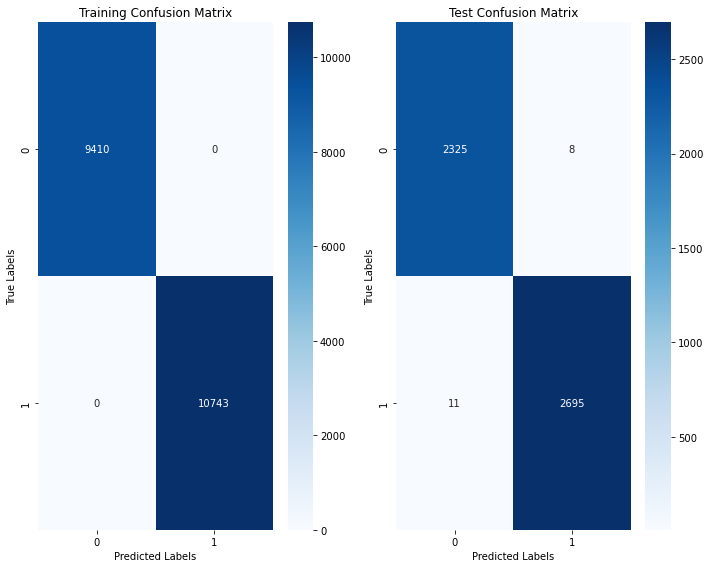

In [1]:
import os
import joblib
import itertools
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

"""Datasets Importation"""

train = pd.read_csv('Train_data.csv')
test = pd.read_csv('Test_data.csv')

"""PreProcessing"""

total = train.shape[0]
missing_columns = [col for col in train.columns if train[col].isnull().sum() > 0]
for col in missing_columns:
    null_count = train[col].isnull().sum()
    per = (null_count / total) * 100
    print(f"{col}: {null_count} ({round(per, 3)}%)")

"""Encoding"""

def le(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            label_encoder = LabelEncoder()
            df[col] = label_encoder.fit_transform(df[col])

le(train)
le(test)

X_train = train.drop(['class'], axis=1)
Y_train = train['class']

"""Feature Selection"""

rfc = RandomForestClassifier()

rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_train, Y_train)

feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
selected_features = [v for i, v in feature_map if i == True]

selected_features

"""Training and Testing of the Model"""

X_train = X_train[selected_features]

scale = StandardScaler()
X_train = scale.fit_transform(X_train)
test = scale.fit_transform(test)

x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.80, random_state=2)

# Instantiate the RandomForestClassifier
rfc = RandomForestClassifier()

# Fit the model on the training data
rfc.fit(x_train, y_train)

# Get the feature names after fitting
feature_names = selected_features

# Print the selected features
print("Selected Features:")
print(selected_features)

# Print the feature names after fitting
print("Feature Names after Fit:")
print(feature_names)

# Print the classification report for training data
y_train_pred = rfc.predict(x_train)
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

# Print the classification report for test data
y_test_pred = rfc.predict(x_test)
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Calculate and print the accuracy scores separately
train_accuracy = rfc.score(x_train, y_train)
test_accuracy = rfc.score(x_test, y_test)
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

"""Saving the Model and Scaler"""

joblib.dump(rfc, "random_forest_model.pkl")
joblib.dump(scale, "scaler1.pkl")

# Calculate and print the ROC AUC scores
y_train_prob = rfc.predict_proba(x_train)[:, 1]
y_test_prob = rfc.predict_proba(x_test)[:, 1]

train_roc_auc = roc_auc_score(y_train, y_train_prob)
test_roc_auc = roc_auc_score(y_test, y_test_prob)

print(f"Training ROC AUC Score: {train_roc_auc:.4f}")
print(f"Test ROC AUC Score: {test_roc_auc:.4f}")

# Calculate the confusion matrix
train_confusion_matrix = confusion_matrix(y_train, y_train_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)

# Plotting the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
sns.heatmap(train_confusion_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.subplot(1, 2, 2)
sns.heatmap(test_confusion_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tight_layout()
plt.show()
